<a href="https://colab.research.google.com/github/CarmenTheodoraCraciun/HairClasification/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importarea biblotecilor si clonarea repo-ului

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [9]:
# !git clone https://github.com/CarmenTheodoraCraciun/HairClasification.git

# Pregatirea datelor
Incarcarea datelor si labelurilor


In [10]:
def load_images_and_labels(input_dir, size=(128, 128)):
    images = []
    labels = []
    for category in os.listdir(input_dir):
        category_dir = os.path.join(input_dir, category)
        if os.path.isdir(category_dir):
            for img_name in os.listdir(category_dir):
                img_path = os.path.join(category_dir, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, size)
                    images.append(img)
                    labels.append(category)
    return np.array(images), np.array(labels)

Setarea directorului de input si incarcarea labelurilor

In [11]:
input_dir = './HairClasification/processData'
images, labels = load_images_and_labels(input_dir)

Impartirea setului de date in antrenament si test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

##Normalizarea imaginiilor
* pentru a contine doar valori de 0 si 1

In [13]:
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0

##One-hot encoding

One-hot encoding este o tehnică folosită pentru a converti datele categorice într-un format numeric pe care un model de învățare automată îl poate înțelege. Exemplu [0,0,0,1,0] înseamnă că părul este drept.

In [14]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

#Augumentarea datelor
* este o tehnică folosită în învățarea automată și procesarea imaginilor pentru a crește diversitatea și cantitatea de date de antrenament prin aplicarea unor transformări asupra datelor existente (rotație, translație, flip etc)
* scopul augmentării este de a îmbunătăți performanța și generalizarea modelului
* definește un generator pentru augmentarea datelor de antrenament.


In [15]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Pregatirea datelor de antrenament si validare

In [16]:
train_datagen = datagen.flow(X_train_normalized, y_train_categorical, batch_size=32)
validation_datagen = ImageDataGenerator().flow(X_test_normalized, y_test_categorical, batch_size=32)

#Construirea modelului

## Incarcarea in modelul preantrenat VGG16

VGG16 este un model de rețea neurală convoluțională (CNN) binecunoscut și puternic, dezvoltat de echipa de cercetare de la Visual Geometry Group (VGG) de la Universitatea din Oxford. Numele său, VGG16, derivă din structura sa de 16 straturi adânci de rețea neurală.

In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

##Construirea peste VGG16

In [18]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

#Compilarea si antrenarea

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history = model.fit(train_datagen, epochs=20, validation_data=validation_datagen)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 412s 8s/step - accuracy: 0.4134 - loss: 2.4743 - val_accuracy: 0.5965 - val_loss: 1.6590
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 410s 8s/step - accuracy: 0.5926 - loss: 1.5760 - val_accuracy: 0.6717 - val_loss: 1.2144
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 444s 8s/step - accuracy: 0.6439 - loss: 1.2706 - val_accuracy: 0.6491 - val_loss: 1.1729
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 460s 9s/step - accuracy: 0.6434 - loss: 1.1574 - val_accuracy: 0.7093 - val_loss: 0.9770
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 435s 8s/step - accuracy: 0.6843 - loss: 1.0083 - val_accuracy: 0.7469 - val_loss: 0.8710
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 425s 9s/step - accuracy: 0.7262 - loss: 0.9021 - val_accuracy: 0.7494 - val_loss: 0.9255
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 424s 8s/step - accuracy: 0.7362 - loss: 0.8427 - val_accuracy: 0.7368 - val_loss: 0.8721
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 504s 10s/step - accuracy: 0.7417 - loss: 0.8075 - val_accuracy: 0.7243 - 

#Evaluarea modelului

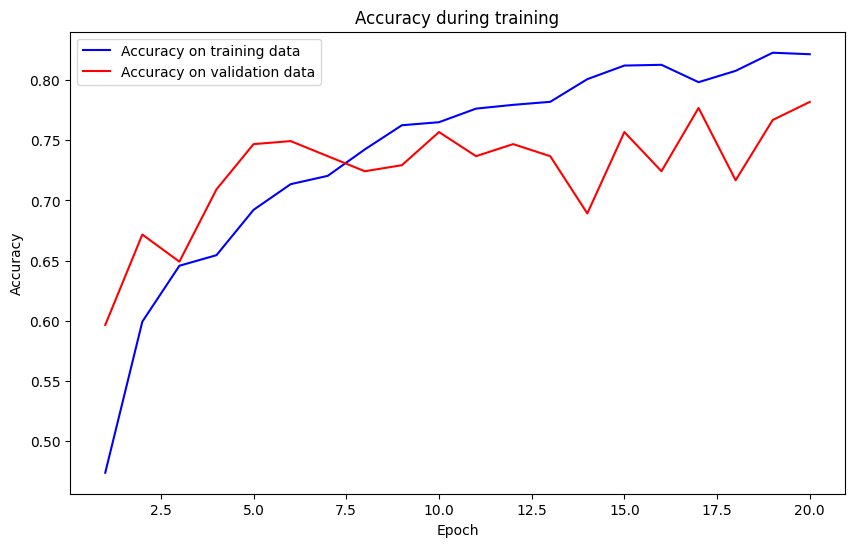

In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'b', label='Accuracy on training data')
plt.plot(epochs, val_accuracy, 'r', label='Accuracy on validation data')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
loss, accuracy = model.evaluate(X_test_normalized, y_test_categorical)
print(f'Test accuracy: {accuracy:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.7862 - loss: 0.6104
Test accuracy: 0.7820


In [24]:
y_pred_encoded = model.predict(X_test_normalized)
y_pred = np.argmax(y_pred_encoded, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step
              precision    recall  f1-score   support

       curly       0.81      0.82      0.82       111
  dreadlocks       0.75      0.85      0.79        84
       kinky       0.68      0.70      0.69        40
    straight       0.84      0.82      0.83       102
        wavy       0.75      0.61      0.67        62

    accuracy                           0.78       399
   macro avg       0.77      0.76      0.76       399
weighted avg       0.78      0.78      0.78       399



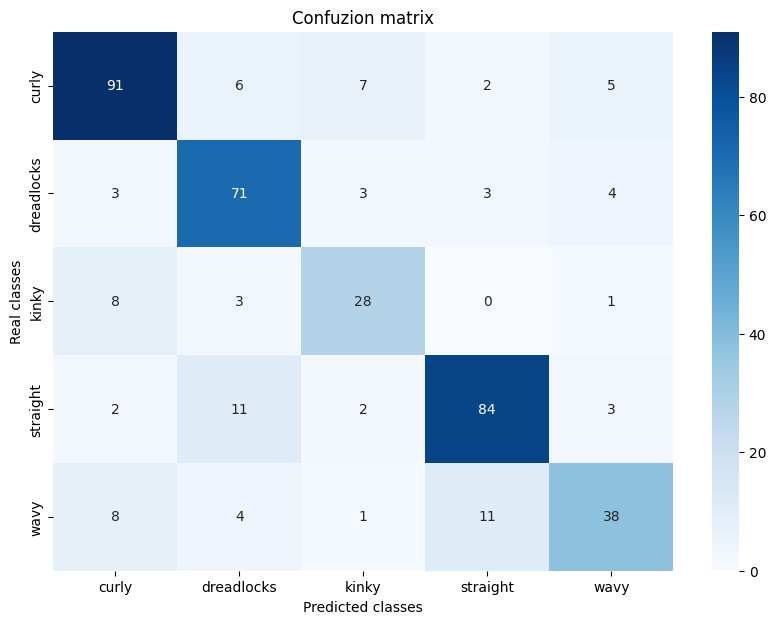

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_df, annot=True, cmap="Blues", fmt="d")
plt.title("Confuzion matrix")
plt.ylabel("Real classes")
plt.xlabel("Predicted classes")
plt.show()